### Correlation method for Bigwig files
I used Spearman correlation to compare ChIP-seq signal profiles across the genome between the samples. Spearman is based on ranked values and does not assume a normal distribution, making it better for genomic data that often violate this assumption. It's also less affected by outliers or differences in signal magnitude, making it ideal for comparing the general pattern of enrichment. 

### Reproducible Peaks (bedtools)
I used bedtools intersect with a 50% reciprocal overlap (using the flags: -f 0.5 -r) to create a consensus peak set shared between both replicates, ensuring only reproducible peaks were retained for downstream analysis, which reduces noise and increases confidence in the final peak set.

### Removing blacklisted region
I used bedtools intersect (-v flag) to filter out any peaks that overlapped with the blacklist file by even 1 base pair.  This approach follows standard practice in ChIP-seq analysis to eliminate genomic regions known to produce artificial or noisy signals and only clean, high-confidence peaks remained for downstream analysis.

### Description of Signal Intensity plots
These plots show the signal from the IP_rep1 and IP_rep2 samples across gene bodies in the hg38 genome. I used computeMatrix function with 2000 bp padding to create a matrix of read counts around genes, and then plotted the data with plotProfile function, both offered by deeptools. Both samples show a strong peak around the transcription start site (TSS), suggesting that the IP samples captured factors active at gene promoters, as expected for ChIP-seq data, as TSS is where the chromatin becomes accessible. 

![Alt text](results/IP_rep1_signal_coverage.png)

![Alt text](results/IP_rep2_signal_coverage.png)

## Motifs

In [2]:
import pandas as pd
motifs = pd.read_csv('results/motifs/knownResults.txt', sep='\t')
motifs.head(10)

,Motif Name,Consensus,P-value,Log P-value,q-value (Benjamini),# of Target Sequences with Motif(of 3026),% of Target Sequences with Motif,# of Background Sequences with Motif(of 43415),% of Background Sequences with Motif
0,RUNX(Runt)/HPC7-Runx1-ChIP-Seq(GSE22178)/Homer,SAAACCACAG,0.000000e+00,-966.4,0.0,923.0,30.50%,2309.7,5.32%
1,RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer,AAACCACARM,1.000000e-310,-716.0,0.0,925.0,30.57%,3194.7,7.35%
2,RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer,NWAACCACADNN,1.000000e-209,-481.9,0.0,704.0,23.27%,2629.3,6.05%
3,RUNX-AML(Runt)/CD4+-PolII-ChIP-Seq(Barski_et_a...,GCTGTGGTTW,1.000000e-189,-437.3,0.0,648.0,21.41%,2431.5,5.60%
4,Foxa2(Forkhead)/Liver-Foxa2-ChIP-Seq(GSE25694)...,CYTGTTTACWYW,1.000000e-100,-231.8,0.0,387.0,12.79%,1553.5,3.58%
5,FOXA1(Forkhead)/LNCAP-FOXA1-ChIP-Seq(GSE27824)...,WAAGTAAACA,1.000000e-91,-209.7,0.0,474.0,15.66%,2386.5,5.49%
6,FOXA1(Forkhead)/MCF7-FOXA1-ChIP-Seq(GSE26831)/...,WAAGTAAACA,1.000000e-86,-199.3,0.0,412.0,13.62%,1942.4,4.47%
7,GRHL2(CP2)/HBE-GRHL2-ChIP-Seq(GSE46194)/Homer,AAACYKGTTWDACMRGTTTB,1.000000e-86,-198.8,0.0,270.0,8.92%,896.7,2.06%
8,Fosl2(bZIP)/3T3L1-Fosl2-ChIP-Seq(GSE56872)/Homer,NATGASTCABNN,1.000000e-80,-184.9,0.0,241.0,7.96%,767.2,1.77%
9,FOXM1(Forkhead)/MCF7-FOXM1-ChIP-Seq(GSE72977)/...,TRTTTACTTW,1.000000e-79,-183.2,0.0,417.0,13.78%,2097.6,4.83%


Motif enrichment analysis of the reproducible and filtered peaks revealed strong enrichment for RUNX family transcription factor binding sites, including RUNX1, RUNX2, and RUNX-AML motifs. These motifs were present in over 30.50% of the target sequences, compared to a much lower frequency in background sequences, indicating high specificity. Forkhead family factors such as FOXA1 and Foxa2 were also significantly enriched, suggesting potential regulatory roles by these transcription factors in the observed ChIP-seq peaks. The presence of motifs like GRHL2, FOSL2, and FOXM1 further supports the involvement of multiple regulatory pathways. Overall, the results suggest that RUNX and Forkhead transcription factors may be key drivers of the DNA-binding activity captured in these samples.

# Week 4

## Methods

ChIP-seq data processing and analysis were performed using a custom Nextflow pipeline with DSL2 syntax. The workflow began by loading raw FASTQ files from a provided CSV sample sheet. Initial quality control was carried out using FastQC. Adapter trimming was performed using Trimmomatic, after which reads were aligned to the hg38 reference genome using Bowtie2. The reference genome was indexed prior to alignment.

Aligned BAM files were then sorted and indexed using SAMtools, and alignment quality was assessed using flagstat. DeepTools’ bamCoverage was then used to generate BigWig coverage tracks. Outputs from FastQC, trimming, and alignment statistics were merged and summarized using MultiQC.

To evaluate consistency between IP samples, BigWig files were summarized using multiBigwigSummary, followed by a Spearman correlation plot generated via plotCorrelation. Reproducible peaks were identified by intersecting narrowPeak files from two replicates using Bedtools with 50% reciprocal overlap. Peaks overlapping the hg38 ENCODE blacklist were removed using bedtools intersect -v.

Filtered reproducible peaks were annotated using HOMER’s annotatePeaks.pl, with custom annotation provided via a reference genome FASTA and GTF file. Read coverage over annotated gene regions was quantified using DeepTools’ computeMatrix in scale-regions mode, with 2000 bp upstream and downstream padding. Signal profiles across gene bodies were visualized using plotProfile.

Finally, HOMER’s findMotifsGenome.pl was used to perform motif enrichment analysis on the filtered peak set. All tools were executed within isolated Conda environments and containerized via Biocontainers-compatible Singularity images for reproducibility.

## QC Comment on the multiQC report

 Across all samples, base quality scores are high, with the majority of reads exhibiting Phred scores above 30 and only a minor fraction falling below acceptable quality thresholds. Trimming was successful, with nearly all reads surviving post-processing, and adapter content remained low across positions, indicating effective removal of adapter sequences. GC content across samples appears normally distributed and consistent with expectations, suggesting no major contamination or bias. However, a significant concern is the high level of sequence duplication, particularly in the IP samples—IP_rep2 shows over 74% duplicated reads, with duplication levels also elevated in IP_rep1. This suggests potential PCR overamplification or low library complexity in immunoprecipitated samples. In contrast, the Input samples appear to have retained better complexity, though detailed duplication metrics for them were not explicitly shown in all figures. Overall, while the sequence quality and trimming performance are robust, the high duplication rates in the IP samples should be addressed by duplicate removal during downstream analysis to ensure reliable interpretation of enrichment and binding profiles.

## Comparing with Paper

In [3]:
#load libraries
import pandas as pd
import requests
from io import BytesIO
import gzip
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2

In [4]:
# GEO RNA-seq results URL
rna_seq_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75070/suppl/GSE75070_MCF7_shRUNX1_shNS_RNAseq_log2_foldchange.txt.gz"

# Download the data and read it into a pandas DataFrame
response = requests.get(rna_seq_url)
with gzip.open(BytesIO(response.content), 'rt') as f:
    rna_seq_df = pd.read_csv(f, sep='\t', comment='!', low_memory=False)

# Read the peak annotation file
peak_path = "./results/annotated_peaks.txt"
peak_df = pd.read_csv(peak_path, sep="\t")

In [7]:
peak_df.head()
len(peak_df)

3026

Replicating figure 2F

/scratch/344064.1.ood/ipykernel_915168/549833415.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Up-regulated\n±5kb of TSS', 'Down-regulated\n±5kb of TSS',


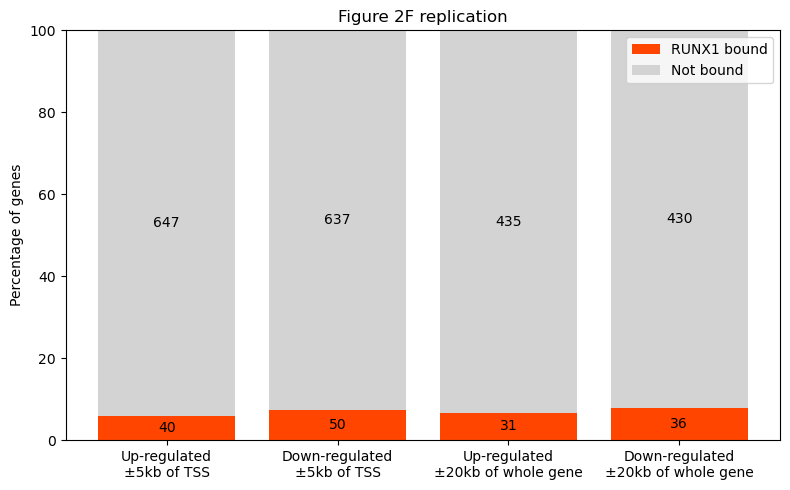

In [5]:
# Significantly differentially expressed genes
deg_up   = rna_seq_df[(rna_seq_df['log2FoldChange'] > 1) & (rna_seq_df['padj'] < 0.01)].copy()
deg_down = rna_seq_df[(rna_seq_df['log2FoldChange'] < -1) & (rna_seq_df['padj'] < 0.01)].copy()

# Peaks existing in TSS ±5kb
peak_df['within_5kb_TSS'] = peak_df['Distance to TSS'].abs() <= 5000

# Merging DEG data with peak data
peak_df = peak_df.rename(columns={"Gene Name": "genename"})
up_merged   = pd.merge(deg_up, peak_df, on='genename', how='left')
down_merged = pd.merge(deg_down, peak_df, on='genename', how='left')

def count_bound_genes(df, region="tss"):
    total_genes = df['genename'].nunique()
    if region == "tss":
        bound = df[df['within_5kb_TSS'] == True]['genename'].nunique()
    elif region == "gene":
        bound = df[df['Distance to TSS'].abs() <= 20000]['genename'].nunique()
    else:
        bound = 0
    return bound, total_genes - bound

plot_data = []

for label, data in zip(["Up", "Down"], [up_merged, down_merged]):
    tss_bound, tss_unbound = count_bound_genes(data, region="tss")
    plot_data.append({'Condition': f"{label}-TSS", 'Bound': tss_bound, 'Not Bound': tss_unbound})

    gene_bound, gene_unbound = count_bound_genes(data, region="gene")
    plot_data.append({'Condition': f"{label}-Gene", 'Bound': gene_bound, 'Not Bound': gene_unbound})

# Data for plotting
plot_df = pd.DataFrame(plot_data)
plot_df['Total'] = plot_df['Bound'] + plot_df['Not Bound']
plot_df['% Bound'] = plot_df['Bound'] / plot_df['Total'] * 100
plot_df['% Not Bound'] = plot_df['Not Bound'] / plot_df['Total'] * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(plot_df['Condition'], plot_df['% Bound'], color='orangered', label='RUNX1 bound')

ax.bar(plot_df['Condition'], plot_df['% Not Bound'], bottom=plot_df['% Bound'], color='lightgray', label='Not bound')

# Lable Aesthetics 
for i, row in plot_df.iterrows():
    ax.text(i, row['% Bound']/2, f"{row['Bound']}", ha='center', va='center', color='black', fontsize=10)
    ax.text(i, row['% Bound'] + row['% Not Bound']/2, f"{row['Not Bound']}", ha='center', va='center', color='black', fontsize=10)

ax.set_ylabel('Percentage of genes')
ax.set_ylim(0, 100)
ax.set_xticklabels(['Up-regulated\n±5kb of TSS', 'Down-regulated\n±5kb of TSS',
                    'Up-regulated\n±20kb of whole gene', 'Down-regulated\n±20kb of whole gene'])
ax.set_title('Figure 2F replication')
ax.legend()

plt.tight_layout()
plt.show()

The recreated figure and the original published figure show clear differences in the number of RUNX1-bound genes, particularly within the ±20kb whole gene categories. While the recreated figure reports significantly fewer overlaps (e.g. 31 vs. 161 for up-regulated genes), this discrepancy likely arises from differences in gene region definitions, annotation files, or computational methods used for intersecting RUNX1 peaks with gene coordinates. For example, the original figure may have used a more inclusive definition of gene boundaries or accounted for alternative transcripts and enhancers more comprehensively. Additionally, technical differences in the ChIP-seq peak sets or tools (e.g.bedtools vs. HOMER) could also contribute. Combining the ±5kb TSS and ±20kb whole gene analyses enables a more complete understanding of RUNX1’s regulatory role, capturing both promoter-proximal and distal enhancer-mediated effects, which helps distinguish direct transcriptional regulation from broader genomic influence.

checkpoint - found needed files for 2d and 2e

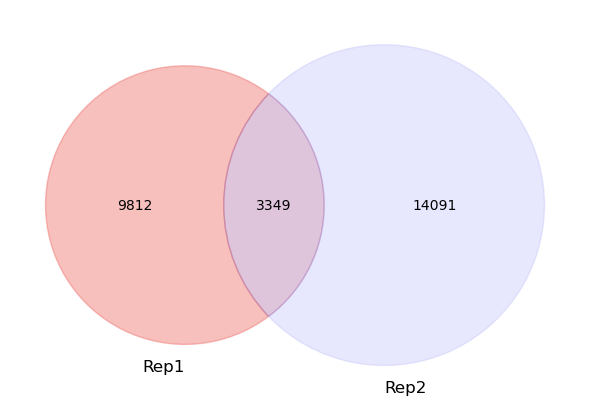

In [11]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
def count_lines(filepath):
    with open(filepath) as f:
        return sum(1 for _ in f)

# Count peaks in each file
rep1_total = count_lines('/projectnb/bf528/materials/project-2-chipseq/refs/rep1_peaks.narrowPeak')
rep2_total = count_lines('/projectnb/bf528/materials/project-2-chipseq/refs/rep2_peaks.narrowPeak')
common = count_lines("./results/repr_peaks.bed")

# Calculate unique peaks
rep1_only = rep1_total - common
rep2_only = rep2_total - common

# Venn diagram
plt.figure(figsize=(6,5))
v = venn2(subsets=(rep1_only, rep2_only, common), set_labels=("Rep1", "Rep2"))

# Set colors for the circles and intersection
v.get_patch_by_id('10').set_color('#EC625C')  # Rep1
v.get_patch_by_id('01').set_color('#C4C4FA')  # Rep2
v.get_patch_by_id('11').set_color('#AD6EA8')  # common

plt.tight_layout()
plt.show()

The number of peaks observed in the generated Venn diagram differs from those reported in the original study. In my analysis, both replicates showed a substantially higher number of unique peaks, while the number of overlapping peaks was slightly lower. These discrepancies could stem from differences in peak-calling parameters or filtering criteria such as q-value thresholds or blacklist region removal. Additionally, the method used to define reproducible peaks—such as IDR versus simple coordinate overlap—can significantly impact the final counts. These variations highlight the importance of standardized, reproducible pipelines for peak identification in ChIP-seq analysis.

### Replicating more figures

In [2]:
import pandas as pd
data_S2A = {
    "Sample Name": ["RUNX1 ChIP 1", "RUNX1 ChIP 2", "INPUT 1", "INPUT 2"],
    "Biological Replicate": [1, 2, 1, 2],
    "Raw Reads": ["29,404,318", "29,690,027", "30,075,142", "10900442"],
    "Mapped Reads": ["27,619,672", "28,035,074", "28.9M", ""]
}

df_S2A = pd.DataFrame(data_S2A)
df_S2A


,Sample Name,Biological Replicate,Raw Reads,Mapped Reads
0,RUNX1 ChIP 1,1,"29,404,318","27,619,672"
1,RUNX1 ChIP 2,2,"29,690,027","28,035,074"
2,INPUT 1,1,"30,075,142",28.9M
3,INPUT 2,2,10900442,


Yes, there are notable differences between the reported raw and mapped read counts across the samples. While RUNX1 ChIP 1 and 2 have high mapping efficiencies with mapped reads closely approaching their respective raw read totals, the INPUT samples show more variability. INPUT 1 has a similar raw read count to the ChIP samples but reports a rounded mapped read count (“28.9M”). INPUT 2, in contrast, has a significantly lower raw read count (~10.9 million), and its mapped read count is not reported (probably wasnt passed correctly to multi_qc)These discrepancies can be attributed to several factors. One possibility is biological or technical variability between samples, such as differences in sequencing depth, library complexity, or sample degradation. Another contributing factor could be differences in mapping efficiency, as ChIP samples typically enrich for specific genomic regions and map more effectively, whereas Input samples are more heterogeneous and may include a higher proportion of reads from repetitive or poorly mappable regions.

In [4]:
import pandas as pd
peak_df = pd.read_csv("./results/annotated_peaks.txt", sep="\t", comment='#')

# Extract promoter-TSS
promoter_df = peak_df[peak_df["Annotation"].str.contains("promoter-TSS", na=False)]

# Extract gene names
gene_list = promoter_df["Gene Name"].dropna().unique()

# Save gene names to a text file
with open("gene_list.txt", "w") as f:
    for gene in gene_list:
        f.write(gene + "\n")

gene_list

array(['NOTCH2NLA', 'NBPF14', 'NOTCH2NLC', ..., 'ZCCHC14-DT', 'NR6A1',
       'XPO5'], shape=(1295,), dtype=object)

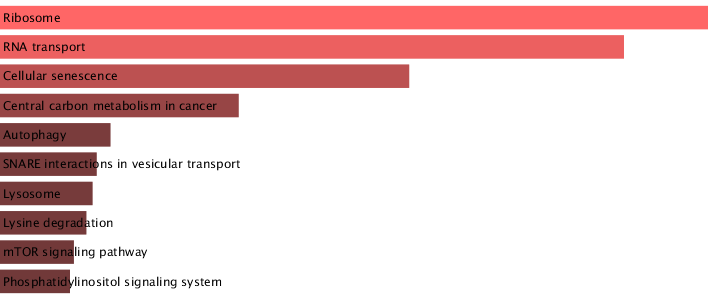

In [6]:
from IPython.display import Image

# Display a Kegg PNG file
Image(filename='KEGG_2021_Human_bar_graph.png')

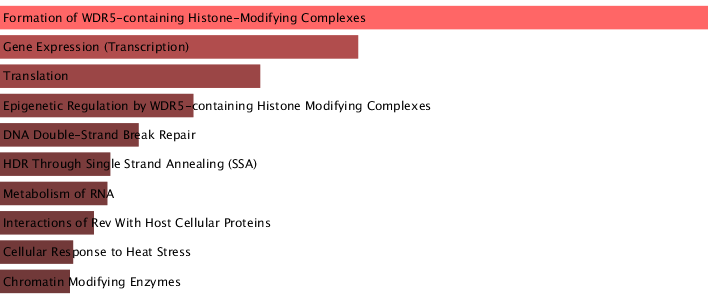

In [8]:
# Display Reactome pathways
Image(filename='Reactome_Pathways_2024_bar_graph.png')

To investigate the functional relevance of genomic regions bound by RUNX1 in breast cancer cells, we first obtained a list of genes associated with annotated peaks from ChIP-seq data. Peaks annotated to "promoter-TSS" regions were extracted using pandas, and the corresponding gene names were saved into a text file. This gene list was used as input for pathway enrichment analysis using the Enricher tool (https://maayanlab.cloud/Enrichr/). Analyses were conducted against Reactome and KEGG pathway databases to identify enriched biological processes and signaling pathways associated with RUNX1-bound regions.

The enrichment analysis revealed strong overrepresentation of pathways related to transcriptional regulation and RNA metabolism, including “Formation of WDR5-containing Histone-Modifying Complexes”, “Gene Expression”, and “RNA Transport”. These results are biologically meaningful, considering that RUNX1 is a transcription factor with known roles in chromatin remodeling and gene regulation. The prominence of chromatin- and RNA-related pathways suggests that RUNX1 binding is tightly linked to transcriptional control and mRNA processing in breast cancer cells. The identification of cellular senescence and autophagy in KEGG further supports RUNX1's involvement in broader cellular responses to stress and transformation, aligning with its proposed role in maintaining genome organization and potentially influencing tumor progression in breast cancer.